# Replication for results in Davidson et al. 2017. "Automated Hate Speech Detection and the Problem of Offensive Language"

In [7]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn
import torch
from tqdm import tqdm
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split

%matplotlib inline

## Download nltk files if necessary

In [9]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/omrihabot/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/omrihabot/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

## Loading the data

In [10]:
# df = pd.read_csv("data/labeled_data.csv", index_col=0)
df = pd.read_pickle("data/labeled_data.p")

In [11]:
df

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...
25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [12]:
df.describe()

,count,hate_speech,offensive_language,neither
count,24783.000000,24783.000000,24783.000000,24783.000000
mean,3.243473,0.280515,2.413711,0.549247
std,0.883060,0.631851,1.399459,1.113299
min,3.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,2.000000,0.000000
50%,3.000000,0.000000,3.000000,0.000000
75%,3.000000,0.000000,3.000000,0.000000
max,9.000000,7.000000,9.000000,9.000000


In [13]:
df.columns

Index(['count', 'hate_speech', 'offensive_language', 'neither', 'class',
       'tweet'],
      dtype='object')

### Columns key:
count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).


hate_speech = number of CF users who judged the tweet to be hate speech.


offensive_language = number of CF users who judged the tweet to be offensive.


neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.


class = class label for majority of CF users.

    0 - hate speech
    1 - offensive  language
    2 - neither

tweet = raw tweet text


In [15]:
tweets = df[['tweet']]
y = df[['class']]

In [14]:
# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"
model.to(device)
print(device)

optimizer = AdamW(model.parameters(), lr=1e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


mps


In [15]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }


train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["tweet"].tolist(), df["class"].tolist(), test_size=0.2, stratify=df["class"]
)

train_dataset = HateSpeechDataset(train_texts, train_labels, tokenizer)
val_dataset = HateSpeechDataset(val_texts, val_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

In [16]:
epochs = 3
model.train()

for epoch in range(epochs):
    total_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")


  1%|          | 13/1240 [00:09<15:09,  1.35it/s] 


KeyboardInterrupt: 

In [22]:
model.eval()
model.to(device)
correct = 0
total = 0

with torch.no_grad():
    for batch in tqdm(val_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Validation Accuracy: {correct / total:.4f}")
print(f"Predictions: {preds.tolist()}")

Validation Accuracy: 0.9524
Predictions: [1, 1, 1, 1, 1, 2, 1, 2, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2]


In [30]:
model.eval()
model.to(device)
correct = 0
total = 0

full_dataset = HateSpeechDataset(df["tweet"].tolist(), df["class"].tolist(), tokenizer)
full_dataloader = DataLoader(full_dataset, batch_size=64)

predictions = []

with torch.no_grad():
    for batch in tqdm(full_dataloader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        predictions.extend(preds.tolist())

        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Accuracy: {correct / total:.4f}")
report = classification_report( df["class"].tolist(), predictions )
print(report)

100%|██████████| 388/388 [03:19<00:00,  1.94it/s]

Accuracy: 0.9533
              precision    recall  f1-score   support

           0       0.72      0.60      0.65      1430
           1       0.97      0.98      0.97     19190
           2       0.97      0.96      0.96      4163

    accuracy                           0.95     24783
   macro avg       0.88      0.85      0.86     24783
weighted avg       0.95      0.95      0.95     24783



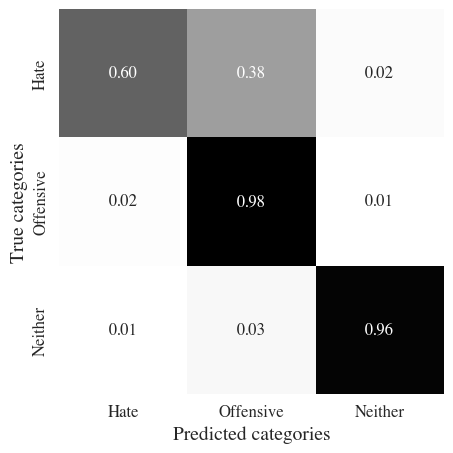

In [31]:
plt.rc('pdf', fonttype=42)
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = False
plt.rcParams['font.serif'] = 'Times'
plt.rcParams['font.family'] = 'serif'
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix( df["class"].tolist(), predictions )
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
# plt.ylabel(r'\textbf{True categories}',fontsize=14)
# plt.xlabel(r'\textbf{Predicted categories}',fontsize=14)
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

# Uncomment line below if you want to save the output
# plt.savefig('confusion.pdf')

In [27]:
save_directory = "./bert_fine_tuned"

model.save_pretrained(save_directory)

torch.save({
    'model_state_dict': model.state_dict(),
    'config': model.config,
}, f"{save_directory}/pytorch_model_checkpoint.pt")

In [20]:
save_directory = "./bert_fine_tuned"
model = BertForSequenceClassification.from_pretrained(save_directory)

In [31]:
checkpoint = torch.load(f"{save_directory}/pytorch_model_checkpoint.pt")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL transformers.models.bert.configuration_bert.BertConfig was not an allowed global by default. Please use `torch.serialization.add_safe_globals([BertConfig])` or the `torch.serialization.safe_globals([BertConfig])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

## Test

In [34]:
tweets = df.tweet

In [35]:
stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()


def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

In [36]:
#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names_out())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

/Users/omrihabot/Documents/Columbia/Semester 2/ML for DS/HW2/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/omrihabot/Documents/Columbia/Semester 2/ML for DS/HW2/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  warnings.warn(


In [37]:
#Get POS tags for tweets and save as a string
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

In [38]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

In [39]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names_out())}

In [40]:
#Now get other features
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.

    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(tweet)

    words = preprocess(tweet) #Get text only

    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))

    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)

    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

In [41]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound", "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

In [42]:
feats = get_feature_array(tweets)

In [60]:
#Now join them all up
predictions = np.array(predictions).reshape((-1,1))
#M = np.concatenate([tfidf,pos,feats],axis=1)
M = np.concatenate([tfidf,pos,feats, predictions],axis=1)


In [61]:
M.shape

(24783, 4024)

In [62]:
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

In [63]:
X = pd.DataFrame(M)
y = df['class'].astype(int)

In [64]:
select = SelectFromModel(LogisticRegression(class_weight='balanced',penalty="l1",C=0.01, solver='liblinear'))
X_ = select.fit_transform(X,y)

In [65]:
model = LinearSVC(class_weight='balanced',C=0.01, penalty='l2', loss='squared_hinge',multi_class='ovr').fit(X_, y)

In [66]:
model = LogisticRegression(class_weight='balanced',penalty='l2',C=0.01, max_iter=10000).fit(X_,y)

In [67]:
y_preds = model.predict(X_)

In [68]:
report = classification_report( y, y_preds )

In [69]:
print(report)

              precision    recall  f1-score   support

           0       0.32      0.84      0.47      1430
           1       0.98      0.85      0.91     19190
           2       0.92      0.97      0.94      4163

    accuracy                           0.87     24783
   macro avg       0.74      0.89      0.77     24783
weighted avg       0.93      0.87      0.89     24783



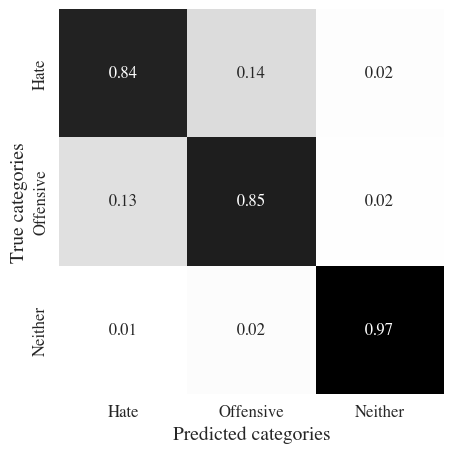

In [70]:
plt.rc('pdf', fonttype=42)
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = False
plt.rcParams['font.serif'] = 'Times'
plt.rcParams['font.family'] = 'serif'
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
# plt.ylabel(r'\textbf{True categories}',fontsize=14)
# plt.xlabel(r'\textbf{Predicted categories}',fontsize=14)
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

# Uncomment line below if you want to save the output
# plt.savefig('confusion.pdf')